# 数据读取与分析

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import stats
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, AICScore
from pgmpy.inference import VariableElimination
import pandas as pd
from tqdm import tqdm
import pickle
import os
from VAEModule.VAEModel import *
from VAEModule.BayesNetwork import *
import random


def set_seed(seed=42):
    """设置所有随机种子以确保可复现性"""
    # Python内置随机数
    random.seed(seed)

    # NumPy随机数
    np.random.seed(seed)

    # PyTorch CPU随机数
    torch.manual_seed(seed)

    # PyTorch GPU随机数（所有GPU）
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN确定性设置
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # PyTorch 2.0+ 可选：更严格的确定性模式
    # torch.use_deterministic_algorithms(True)


# 在程序开始时调用
set_seed(42)
class DifferentiableBayesianNetwork:
    """
    可微分的贝叶斯网络概率计算
    用于DiT的classifier guidance
    """
    
    def __init__(self, bn_model, device='cuda'):
        """
        参数:
            bn_model: 训练好的BayesianNetworkForLatent模型
            device: 计算设备
        """
        self.bn_model = bn_model
        self.device = device
        self.latent_dim = bn_model.latent_dim
        self.n_bins = bn_model.n_bins
        
        # 将离散化边界转换为torch tensor
        self.bin_edges_tensor = {}
        for i in range(self.latent_dim):
            edges = torch.FloatTensor(bn_model.bin_edges[i]).to(device)
            self.bin_edges_tensor[i] = edges
        
        # 提取CPD (条件概率分布) 并转换为torch tensor
        self.cpds = self._extract_cpds()
        
        # 获取网络结构信息
        self.structure_info = bn_model.get_structure_info()
        self.parents_dict = self.structure_info['parents']
        
    def _extract_cpds(self):
        """从pgmpy模型中提取CPD并转换为torch tensor"""
        cpds = {}
        
        for cpd in self.bn_model.model.get_cpds():
            var_name = cpd.variable
            # 获取CPD的值 (numpy array)
            values = cpd.values
            
            # 转换为torch tensor
            cpds[var_name] = torch.FloatTensor(values).to(self.device)
            
        return cpds
    
    def soft_discretize(self, z, temperature=0.1):
        """
        可微分的软离散化
        使用softmax将连续值映射到离散bin的概率分布
        
        参数:
            z: (batch_size, latent_dim) 连续潜变量
            temperature: softmax温度参数，越小越接近hard discretization
            
        返回:
            soft_bins: (batch_size, latent_dim, n_bins) 每个变量在各bin的概率
        """
        batch_size = z.shape[0]
        soft_bins_list = []
        
        for i in range(self.latent_dim):
            # 获取该维度的bin边界
            edges = self.bin_edges_tensor[i]
            n_bins = len(edges) - 1
            
            # 计算到每个bin中心的距离
            # bin中心
            bin_centers = (edges[:-1] + edges[1:]) / 2  # (n_bins,)
            
            # 计算距离: (batch_size, n_bins)
            z_expanded = z[:, i:i+1]  # (batch_size, 1)
            distances = -torch.abs(z_expanded - bin_centers.unsqueeze(0))  # (batch_size, n_bins)
            
            # 使用softmax转换为概率分布
            soft_probs = F.softmax(distances / temperature, dim=1)  # (batch_size, n_bins)
            
            soft_bins_list.append(soft_probs)
        
        # (batch_size, latent_dim, n_bins)
        soft_bins = torch.stack(soft_bins_list, dim=1)
        
        return soft_bins
    
    def compute_log_prob(self, z, temperature=0.1):
        """
        计算潜变量z在贝叶斯网络下的对数概率
        保持梯度可追踪
        
        参数:
            z: (batch_size, latent_dim) 连续潜变量
            temperature: 软离散化的温度参数
            
        返回:
            log_prob: (batch_size,) 每个样本的对数概率
        """
        batch_size = z.shape[0]
        
        # 软离散化
        soft_bins = self.soft_discretize(z, temperature)  # (batch_size, latent_dim, n_bins)
        
        # 计算每个变量的对数概率
        log_probs = []
        
        for node in self.parents_dict.keys():
            node_idx = int(node[1:])  # 'z0' -> 0
            parents = self.parents_dict[node]
            
            # 获取该节点的CPD
            cpd = self.cpds[node]  # CPD tensor
            
            if len(parents) == 0:
                # 无父节点：P(node)
                # cpd shape: (n_bins,)
                node_soft_bins = soft_bins[:, node_idx, :]  # (batch_size, n_bins)
                
                # 计算加权对数概率
                # log P(node) = sum_i p(bin_i) * log(CPD[i])
                cpd_log = torch.log(cpd + 1e-10)  # (n_bins,)
                log_prob = torch.sum(node_soft_bins * cpd_log.unsqueeze(0), dim=1)  # (batch_size,)
                
            else:
                # 有父节点：P(node | parents)
                # 需要根据父节点的状态选择对应的CPD
                
                # 为简化，这里假设最多2个父节点
                # 如果有更多父节点，需要递归处理
                
                if len(parents) == 1:
                    parent_idx = int(parents[0][1:])
                    parent_soft_bins = soft_bins[:, parent_idx, :]  # (batch_size, n_bins)
                    node_soft_bins = soft_bins[:, node_idx, :]  # (batch_size, n_bins)
                    
                    # cpd shape: (n_bins_node, n_bins_parent)
                    # 计算 P(node | parent) = sum_j p(parent=j) * P(node | parent=j)
                    cpd_log = torch.log(cpd + 1e-10)  # (n_bins_node, n_bins_parent)
                    
                    # 边际化父节点
                    # (batch_size, n_bins_node, n_bins_parent)
                    weighted_cpd = cpd_log.unsqueeze(0) * parent_soft_bins.unsqueeze(1)
                    
                    # 对父节点求和
                    marginalized_cpd = torch.sum(weighted_cpd, dim=2)  # (batch_size, n_bins_node)
                    
                    # 加权node的软bins
                    log_prob = torch.sum(node_soft_bins * marginalized_cpd, dim=1)  # (batch_size,)
                    
                elif len(parents) == 2:
                    parent1_idx = int(parents[0][1:])
                    parent2_idx = int(parents[1][1:])
                    parent1_soft_bins = soft_bins[:, parent1_idx, :]  # (batch_size, n_bins)
                    parent2_soft_bins = soft_bins[:, parent2_idx, :]  # (batch_size, n_bins)
                    node_soft_bins = soft_bins[:, node_idx, :]  # (batch_size, n_bins)
                    
                    # cpd shape: (n_bins_node, n_bins_parent1, n_bins_parent2)
                    cpd_log = torch.log(cpd + 1e-10)
                    
                    # 边际化两个父节点
                    # (batch_size, n_bins_node, n_bins_parent1, n_bins_parent2)
                    weighted_cpd = cpd_log.unsqueeze(0) * \
                                   parent1_soft_bins.unsqueeze(1).unsqueeze(3) * \
                                   parent2_soft_bins.unsqueeze(1).unsqueeze(2)
                    
                    # 对父节点求和
                    marginalized_cpd = torch.sum(weighted_cpd, dim=(2, 3))  # (batch_size, n_bins_node)
                    
                    log_prob = torch.sum(node_soft_bins * marginalized_cpd, dim=1)
                
                else:
                    # 超过2个父节点的情况
                    raise NotImplementedError(f"节点 {node} 有 {len(parents)} 个父节点，暂不支持")
            
            log_probs.append(log_prob)
        
        # 总对数概率 = 各节点对数概率之和
        total_log_prob = torch.stack(log_probs, dim=0).sum(dim=0)  # (batch_size,)
        
        return total_log_prob
    
    def compute_prob(self, z, temperature=0.1):
        """
        计算潜变量z的概率
        
        参数:
            z: (batch_size, latent_dim) 连续潜变量
            temperature: 软离散化的温度参数
            
        返回:
            prob: (batch_size,) 每个样本的概率
        """
        log_prob = self.compute_log_prob(z, temperature)
        return torch.exp(log_prob)

def vectorized_distance_score(new_z, all_z):
    """
    new_z: Tensor or ndarray, shape (M, D)
    all_z: Tensor or ndarray, shape (N, D)
    return: shape (M,) vector
    """

    # --- convert to numpy if tensor ---
    is_torch = False
    if 'torch' in str(type(new_z)):
        is_torch = True
        new_z_np = new_z.detach().cpu().numpy()
        all_z_np = all_z.detach().cpu().numpy()
    else:
        new_z_np = new_z
        all_z_np = all_z

    # ||x||^2 term
    new_norm = (new_z_np ** 2).sum(axis=1)           # (M,)
    all_norm = (all_z_np ** 2).sum(axis=1)           # (N,)

    # pairwise squared distance: (M, N)
    dist_sq = new_norm[:, None] + all_norm[None, :] - 2 * new_z_np @ all_z_np.T
    dist_sq = np.maximum(dist_sq, 0)

    # 每一行的平均，再 sqrt，再 sqrt
    out = np.sqrt(np.sqrt(dist_sq.mean(axis=1)))

    if is_torch:
        return torch.from_numpy(out).to(new_z.device)
    return out




# 数据读取
import pandas as pd
import os 
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
family2014 = pd.read_csv('数据/居民出行数据/2014/family_2014.csv',dtype=str)
travel2014 = pd.read_csv('数据/居民出行数据/2014/midtable_2014.csv',dtype=str)
familymember_2014 = pd.read_csv('数据/居民出行数据/2014/family_member_2014.csv',dtype=str)
family2023 = pd.read_csv('数据/居民出行数据/2023/family_total_33169.csv',dtype=str)
travel2023 = pd.read_csv('数据/居民出行数据/2023/midtable_total_33169.csv',dtype=str)
familymember_2023 = pd.read_csv('数据/居民出行数据/2023/familymember_total_33169.csv',dtype=str)
family_cluster = pd.read_csv('数据/family_cluster_new.csv',dtype=str)
## 家庭变量筛选
valid_member_number = familymember_2023.groupby('家庭编号').size().rename('家庭成员数量_real').reset_index()
family2023 = pd.merge(family2023, valid_member_number, on='家庭编号', how='left')
family2023 = family2023[family2023['家庭成员数量'].astype(int) == family2023['家庭成员数量_real']]
valid_family = family2023[['家庭编号']]
familymember_2023 = pd.merge(familymember_2023, valid_family, on='家庭编号', how='inner')
family2023[['家庭成员数量']].value_counts()
## 家庭连续型变量
family2023[['家庭成员数量','家庭工作人口数','机动车数量','脚踏自行车数量','电动自行车数量','摩托车数量','老年代步车数量']]
have_student_family = familymember_2023[familymember_2023['职业'] == '14'].drop_duplicates(['家庭编号'])[['家庭编号']]
have_student_family['have_student'] = 1
family2023 = pd.merge(family2023, have_student_family, on='家庭编号', how='left').fillna({'have_student':0})
## 家庭离散型变量
family2023[['have_student','家庭年收入']]
family2023['家庭年收入'].isna().sum()
## 个人变量筛选
familymember_2023['age'] = 2023 - familymember_2023['出生年份'].astype(int)
familymember_2023['age_group'] = pd.cut(familymember_2023['age'], bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], right=False, labels=['0-5','6-10','11-15','16-20','21-25','26-30','31-35','36-40','41-45','46-50','51-55','56-60','61-65','66-70','71-75','76-80','81-85','86-90','91-95','96-100'])
familymember_2023['age'].max() , familymember_2023['age'].min()
# familymember_2023['age'] = (familymember_2023['age'] - familymember_2023['age'].min()) / (familymember_2023['age'].max() - familymember_2023['age'].min())
## 连续型变量
familymember_2023[['age']]
(familymember_2023[familymember_2023['关系']=='0']['age']).describe()
familymember_2023.loc[familymember_2023['最高学历'].isna(),'最高学历'] = familymember_2023.loc[familymember_2023['最高学历'].isna(),'教育阶段']
## 离散型变量,这里的关系有点不太对，有的户主很小
familymember_2023[['性别','是否有驾照','关系','最高学历','职业']]
familymember_2023['是否有驾照'] = familymember_2023['是否有驾照'].fillna('0')


income_map = {'A':1, 'B':1, 'C':2, 'D':2, 'E':3, 'F':3, 'G':4, 'I':5, 'J':5, 'K':5}
family2023['家庭年收入'] = family2023['家庭年收入'].map(income_map)
familymember_2023['age_group'] = pd.cut(
    familymember_2023['age'],
    bins=range(0, familymember_2023['age'].max() + 6, 5),
    labels=False
)


familymember_2023['age_group'] = familymember_2023['age_group'].fillna(0)
familymember_2023['age'] = familymember_2023['age_group']
# relation_map = {'0':0, '17':1, '1':2, '2':2, '5':2, '6':2, '13':3, '14':3, '15':3, '16':3, '9':3, '10':3, '7':4, '8':4, '11':5, '12':5}
# education_map = {'1':1, '2':1, '3':2, '4':2, '5':3, '6':4, '7':5, '8':6, '9':7}
# occupation_map = {'1':1, '2':1, '3':1, '4':2, '5':2, '6':3, '7':2, '8':3, '9':1, '10':4, '11':4, '12':4, '13':5, '14':6, '15':7, '16':8, '17':8, '18':1, '19':1, '20':8}

# familymember_2023['关系'] = familymember_2023['关系'].map(relation_map)
# familymember_2023['最高学历'] = familymember_2023['最高学历'].map(education_map)
# familymember_2023['职业'] = familymember_2023['职业'].map(occupation_map)
familymember_2023['关系'].value_counts().shape, familymember_2023['最高学历'].value_counts().shape, familymember_2023['职业'].value_counts().shape
from population_data_process_nonclip_reclass import *
## 家庭的变量编码
test = PopulationDataEncoder()
family2023 = pd.merge(family2023,family_cluster[['家庭编号','cluster']], on='家庭编号', how='left')
# 2. 拟合数据 (需要你的实际数据)
test.fit_family_data(family2023)
test.fit_person_data(familymember_2023)


class DiffusionScheduler:
    """扩散调度器"""

    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.num_timesteps = num_timesteps

        # 创建beta调度
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        # 为采样准备的系数
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

    def add_noise(self, x_start, noise, timesteps):
        """添加噪声到原始数据"""
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[timesteps].reshape(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[timesteps].reshape(-1, 1)

        # 对于成员数据，需要额外处理维度
        if len(x_start.shape) == 3:  # member data: [batch, family_size, features]
            sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t.unsqueeze(-1)
            sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t.unsqueeze(-1)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def to(self, device):
        """移动到指定设备"""
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod.to(device)
        self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod.to(device)
        return self


latent_dim = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载VAE模型
model_path = 'VAEModule/vae_best_model.pth'
model_vae = VAE(input_dim=10 + 51 * 8, hidden_dim=1024, latent_dim=latent_dim)
model_vae.load_state_dict(torch.load(model_path, map_location=device))
model_vae = model_vae.to(device)
model_vae.eval()

# 加载贝叶斯网络模型
loaded_bn_model = BayesianNetworkForLatent.load_model('VAEModule/bayesian_network_model.pkl')

# 创建可微分的贝叶斯网络
diff_bn = DifferentiableBayesianNetwork(loaded_bn_model, device=device)

# 测试数据
family_data = torch.FloatTensor(np.load(f'数据/family_sample_improved_cluster.npy')[:, :10]).to(device)
member_data = torch.FloatTensor(np.load(f'数据/family_member_sample_improved_cluster.npy')).to(device)
data = torch.cat((family_data, member_data.view(member_data.size(0), -1)), dim=1)
# 编码到潜空间
with torch.no_grad():
    mu, logvar = model_vae.encode(data)
    all_z = model_vae.reparameterize(mu, logvar)



## 未引导的判断
import glob

family_files = glob.glob("生成数据/人口栅格_*家庭*")
person_files = [f.replace("家庭","个人") for f in family_files]

from tqdm import tqdm
family_data_non = pd.concat([pd.read_csv(f) for f in tqdm(family_files)], ignore_index=True)
person_data_non = pd.concat([pd.read_csv(f) for f in tqdm(person_files)], ignore_index=True)
# ---- Step 1: 计算每个家庭人数 & 起止 index ----
person_number = np.round(
    family_data_non["0"].values * 0.88397094 + 2.38862088
).astype(int)

cum_end = np.cumsum(person_number)
cum_start = cum_end - person_number

max_members = 8
num_families = len(person_number)
feature_dim = person_data_non.shape[1] - 2

# ---- Step 2: 构造一个 (num_families, max_members) 的 index matrix ----
# 对每个家庭制作成员 index：start_i + [0,1,2,...7]
idx = cum_start[:, None] + np.arange(max_members)

# 对越界（成员不足的家庭）的位置设为 -1
mask_valid = (idx < cum_end[:, None])
idx = np.where(mask_valid, idx, -1)

# ---- Step 3: 用高级索引一次性取数据 ----
# person_data 的 shape: (N, feature_dim+2)，我们只取到倒数第2列
person_array = person_data_non.iloc[:, :-2].values

# pad 一行全 0，放到最后，用于处理 idx = -1 的情况
person_array_padded = np.vstack([person_array, np.zeros((1, feature_dim))])

# 将 -1 的 index 映射到 padded 最后一行
idx_safe = np.where(idx == -1, len(person_array), idx)

# ---- Step 4: 一步取出所有家庭成员数据 ----
total_ls_raw_non = person_array_padded[idx_safe]

data_non = np.concatenate([family_data_non.iloc[:,:-2], total_ls_raw_non.reshape(num_families, -1)], axis=1)
bn_judge_ls_non = []
vae_judge_ls_non = []
distance_vae_ls_non = []
for i in tqdm(range(int(data_non.shape[0] / 10000) +1 )):
    batch_data = torch.FloatTensor(data_non[i*10000 : (i+1)*10000]).to(device)

    # 编码到潜空间
    with torch.no_grad():
        mu, logvar = model_vae.encode(batch_data)
        z = model_vae.reparameterize(mu, logvar)

    # 计算概率（需要梯度）
    z_grad = z.clone().requires_grad_(True)
    # 计算对数概率
    log_prob = diff_bn.compute_log_prob(z_grad, temperature=0.1)
    log_prob = torch.nan_to_num(log_prob, nan=-100)
    threshold_bn = torch.tensor(-44.0534).to(device)
    judge_bn = log_prob < threshold_bn

    threshold_vae = torch.tensor(2.733688659593493).to(device)
    distance_vae = vectorized_distance_score(z_grad,all_z)
    distance_vae = torch.nan_to_num(distance_vae, nan=100)
    judge_vae = distance_vae > threshold_vae
    bn_judge_ls_non.append(judge_bn.cpu().numpy())
    vae_judge_ls_non.append(judge_vae.cpu().numpy())
    distance_vae_ls_non.append(distance_vae.cpu().numpy())
    
bn_judge_total_non = np.concatenate(bn_judge_ls_non, axis=0)
vae_judge_total_non = np.concatenate(vae_judge_ls_non, axis=0)
distance_vae_total_non = np.concatenate(distance_vae_ls_non, axis=0)

del bn_judge_ls_non
del vae_judge_ls_non
del distance_vae_ls_non
## 三种类别的数量
## legal
legal = (~bn_judge_total_non).sum() / len(bn_judge_total_non)

print(f'未引导legal:{legal}')
## nonlegal-near_distance
nonlegal1 = (bn_judge_total_non & (~vae_judge_total_non)).sum() / len(bn_judge_total_non)

print(f'未引导nonlegal-near_distance:{nonlegal1}')
## nonlegal-far_distance
nonlegal2 = (bn_judge_total_non & (vae_judge_total_non)).sum() / len(bn_judge_total_non)

print(f'未引导nonlegal-far_distance:{nonlegal2}')

## 加了BN

family_files = glob.glob("生成数据_BN/人口栅格_*家庭*")
person_files = [f.replace("家庭","个人") for f in family_files]

family_data_bn = pd.concat([pd.read_csv(f) for f in tqdm(family_files)], ignore_index=True)
person_data_bn = pd.concat([pd.read_csv(f) for f in tqdm(person_files)], ignore_index=True)

# ---- Step 1: 计算每个家庭人数 & 起止 index ----
person_number = np.round(
    family_data_bn["0"].values * 0.88397094 + 2.38862088
).astype(int)

cum_end = np.cumsum(person_number)
cum_start = cum_end - person_number

max_members = 8
num_families = len(person_number)
feature_dim = person_data_bn.shape[1] - 2

# ---- Step 2: 构造一个 (num_families, max_members) 的 index matrix ----
# 对每个家庭制作成员 index：start_i + [0,1,2,...7]
idx = cum_start[:, None] + np.arange(max_members)

# 对越界（成员不足的家庭）的位置设为 -1
mask_valid = (idx < cum_end[:, None])
idx = np.where(mask_valid, idx, -1)

# ---- Step 3: 用高级索引一次性取数据 ----
# person_data 的 shape: (N, feature_dim+2)，我们只取到倒数第2列
person_array = person_data_bn.iloc[:, :-2].values

# pad 一行全 0，放到最后，用于处理 idx = -1 的情况
person_array_padded = np.vstack([person_array, np.zeros((1, feature_dim))])

# 将 -1 的 index 映射到 padded 最后一行
idx_safe = np.where(idx == -1, len(person_array), idx)

# ---- Step 4: 一步取出所有家庭成员数据 ----
total_ls_raw_bn = person_array_padded[idx_safe]

data_bn = np.concatenate([family_data_bn.iloc[:,:-2], total_ls_raw_bn.reshape(num_families, -1)], axis=1)

bn_judge_ls_bn = []
vae_judge_ls_bn = []
distance_vae_ls_bn = []
for i in tqdm(range(int(data_bn.shape[0] / 10000) +1 )):
    batch_data = torch.FloatTensor(data_bn[i*10000 : (i+1)*10000]).to(device)

    # 编码到潜空间
    with torch.no_grad():
        mu, logvar = model_vae.encode(batch_data)
        z = model_vae.reparameterize(mu, logvar)

    # 计算概率（需要梯度）
    z_grad = z.clone().requires_grad_(True)
    # 计算对数概率
    log_prob = diff_bn.compute_log_prob(z_grad, temperature=0.1)
    log_prob = torch.nan_to_num(log_prob, nan=-100)
    threshold_bn = torch.tensor(-44.0534).to(device)
    judge_bn = log_prob < threshold_bn

    threshold_vae = torch.tensor(2.733688659593493).to(device)
    distance_vae = vectorized_distance_score(z_grad,all_z)
    distance_vae = torch.nan_to_num(distance_vae, nan=100)
    judge_vae = distance_vae > threshold_vae
    bn_judge_ls_bn.append(judge_bn.cpu().numpy())
    vae_judge_ls_bn.append(judge_vae.cpu().numpy())
    distance_vae_ls_bn.append(distance_vae.cpu().numpy())
    
bn_judge_total_bn = np.concatenate(bn_judge_ls_bn, axis=0)
vae_judge_total_bn = np.concatenate(vae_judge_ls_bn, axis=0)
distance_vae_total_bn = np.concatenate(distance_vae_ls_bn, axis=0)

del bn_judge_ls_bn
del vae_judge_ls_bn
del distance_vae_ls_bn
## 三种类别的数量
## legal
legal = (~bn_judge_total_bn).sum() / len(bn_judge_total_bn)

print(f'加了BNlegal:{legal}')
## nonlegal-near_distance
nonlegal1 = (bn_judge_total_bn & (~vae_judge_total_bn)).sum() / len(bn_judge_total_bn)

print(f'加了BNnonlegal-near_distance:{nonlegal1}')
## nonlegal-far_distance
nonlegal2 = (bn_judge_total_bn & (vae_judge_total_bn)).sum() / len(bn_judge_total_bn)

print(f'加了BNnonlegal-far_distance:{nonlegal2}')

/home/test/anaconda3/envs/DiT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


/home/test/anaconda3/envs/DiT/lib/python3.8/site-packages/google/api_core/_python_version_support.py:237: FutureWarning: You are using a non-supported Python version (3.8.20). Google will not post any further updates to google.api_core supporting this Python version. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)


模型已从 VAEModule/bayesian_network_model.pkl 加载


100%|██████████| 1410/1410 [44:53<00:00,  1.91s/it] 


未引导legal:0.27572687834283816
未引导nonlegal-near_distance:0.6556652282980217
未引导nonlegal-far_distance:0.06860789335914014


100%|██████████| 1410/1410 [38:03<00:00,  1.62s/it]

加了BNlegal:0.3010264628196352
加了BNnonlegal-near_distance:0.6989731825354994
加了BNnonlegal-far_distance:3.5464486537007084e-07


In [2]:
## allguidance

family_files = glob.glob("生成数据_allguidance/人口栅格_*家庭*")
person_files = [f.replace("家庭","个人") for f in family_files]

family_data_all = pd.concat([pd.read_csv(f) for f in tqdm(family_files)], ignore_index=True)
person_data_all = pd.concat([pd.read_csv(f) for f in tqdm(person_files)], ignore_index=True)

# ---- Step 1: 计算每个家庭人数 & 起止 index ----
person_number = np.round(
    family_data_all["0"].values * 0.88397094 + 2.38862088
).astype(int)

cum_end = np.cumsum(person_number)
cum_start = cum_end - person_number

max_members = 8
num_families = len(person_number)
feature_dim = person_data_all.shape[1] - 2

# ---- Step 2: 构造一个 (num_families, max_members) 的 index matrix ----
# 对每个家庭制作成员 index：start_i + [0,1,2,...7]
idx = cum_start[:, None] + np.arange(max_members)

# 对越界（成员不足的家庭）的位置设为 -1
mask_valid = (idx < cum_end[:, None])
idx = np.where(mask_valid, idx, -1)

# ---- Step 3: 用高级索引一次性取数据 ----
# person_data 的 shape: (N, feature_dim+2)，我们只取到倒数第2列
person_array = person_data_all.iloc[:, :-2].values

# pad 一行全 0，放到最后，用于处理 idx = -1 的情况
person_array_padded = np.vstack([person_array, np.zeros((1, feature_dim))])

# 将 -1 的 index 映射到 padded 最后一行
idx_safe = np.where(idx == -1, len(person_array), idx)

# ---- Step 4: 一步取出所有家庭成员数据 ----
total_ls_raw_all = person_array_padded[idx_safe]

data_all = np.concatenate([family_data_all.iloc[:,:-2], total_ls_raw_all.reshape(num_families, -1)], axis=1)

bn_judge_ls_all = []
vae_judge_ls_all = []
distance_vae_ls_all = []
for i in tqdm(range(int(data_all.shape[0] / 10000) +1 )):
    batch_data = torch.FloatTensor(data_all[i*10000 : (i+1)*10000]).to(device)

    # 编码到潜空间
    with torch.no_grad():
        mu, logvar = model_vae.encode(batch_data)
        z = model_vae.reparameterize(mu, logvar)

    # 计算概率（需要梯度）
    z_grad = z.clone().requires_grad_(True)
    # 计算对数概率
    log_prob = diff_bn.compute_log_prob(z_grad, temperature=0.1)
    log_prob = torch.nan_to_num(log_prob, nan=-100)
    threshold_all = torch.tensor(-44.0534).to(device)
    judge_all = log_prob < threshold_all

    threshold_vae = torch.tensor(2.733688659593493).to(device)
    distance_vae = vectorized_distance_score(z_grad,all_z)
    distance_vae = torch.nan_to_num(distance_vae, nan=100)
    judge_vae = distance_vae > threshold_vae
    bn_judge_ls_all.append(judge_all.cpu().numpy())
    vae_judge_ls_all.append(judge_vae.cpu().numpy())
    distance_vae_ls_all.append(distance_vae.cpu().numpy())
    
bn_judge_total_all = np.concatenate(bn_judge_ls_all, axis=0)
vae_judge_total_all = np.concatenate(vae_judge_ls_all, axis=0)
distance_vae_total_all = np.concatenate(distance_vae_ls_all, axis=0)

del bn_judge_ls_all
del vae_judge_ls_all
del distance_vae_ls_all
## 三种类别的数量
## legal
legal = (~bn_judge_total_all).sum() / len(bn_judge_total_all)

print(f'加了BNlegal:{legal}')
## nonlegal-near_distance
nonlegal1 = (bn_judge_total_all & (~vae_judge_total_all)).sum() / len(bn_judge_total_all)

print(f'加了BNnonlegal-near_distance:{nonlegal1}')
## nonlegal-far_distance
nonlegal2 = (bn_judge_total_all & (vae_judge_total_all)).sum() / len(bn_judge_total_all)

print(f'加了BNnonlegal-far_distance:{nonlegal2}')

100%|██████████| 1410/1410 [42:49<00:00,  1.82s/it] 

加了BNlegal:0.3102657417812294
加了BNnonlegal-near_distance:0.6897341872897975
加了BNnonlegal-far_distance:7.092897307401417e-08


# 未引导数据

## Wasserstein 距离分布

In [21]:
distance_vae_total_non.mean()

2.5789633

## 样本零多样性验证

In [22]:
family_data_non = family_data_non.iloc[:, :10]

In [23]:
person_data_non = person_data_non.iloc[:, :51]

In [24]:
family_data_non.columns = [i for i in range(family_data_non.shape[1])]
person_data_non.columns = [i for i in range(person_data_non.shape[1])]

In [25]:
n = 33166
results_family_df = family_data_non
results_family_df['have_student'] = results_family_df[[8,9]].values.argmax(axis=1)

results_family_df = results_family_df[[0,1,2,3,4,5,6,7,'have_student']]
results_family_df.columns = ['family_家庭成员数量','family_家庭工作人口数','family_机动车数量','family_脚踏自行车数量','family_电动自行车数量','family_摩托车数量','family_老年代步车数量','income','have_student']

results_family_df.rename(columns = {'income' : 'family_家庭年收入'}, inplace=True)
decode_results_family = test.decode_family_continuous(results_family_df)
for col in decode_results_family.keys():
    results_family_df[f'family_{col}'] = decode_results_family[col]


results_person_df = person_data_non
results_person_df['gender'] = results_person_df[[1,2]].values.argmax(axis=1)
results_person_df['license'] = results_person_df[[3,4]].values.argmax(axis=1)
results_person_df['relation'] = results_person_df.iloc[:,5:21].values.argmax(axis=1)
results_person_df['education'] = results_person_df.iloc[:,21:30].values.argmax(axis=1)
results_person_df['occupation'] = results_person_df.iloc[:,30:50].values.argmax(axis=1)


results_person_df = results_person_df[[0,'gender','license','relation','education','occupation',50]]
results_person_df.columns = ['age','gender','license','relation','education','occupation','label']


results_person_df['age'] = test.decode_person_continuous(results_person_df['age'])['age_actual']

raw_person_df = pd.merge(familymember_2023,family2023[['家庭编号']][:n])
raw_person_df = raw_person_df[['age','性别', '是否有驾照', '关系', '最高学历', '职业']]
encode_member_data = test.encode_person(raw_person_df)
raw_person_dict = {}
raw_person_dict['age'] = encode_member_data['person_age']
raw_person_dict['gender'] = encode_member_data['person_性别'].argmax(axis=1)
raw_person_dict['license'] = encode_member_data['person_是否有驾照'].argmax(axis=1)
raw_person_dict['relation'] = encode_member_data['person_关系'].argmax(axis=1)
raw_person_dict['education'] = encode_member_data['person_最高学历'].argmax(axis=1)
raw_person_dict['occupation'] = encode_member_data['person_职业'].argmax(axis=1)

raw_person_df = pd.DataFrame(raw_person_dict)
raw_person_df['age'] = test.decode_person_continuous(raw_person_df['age'])['age_actual']
raw_family_df = family2023[:n][['家庭成员数量','家庭工作人口数','机动车数量','脚踏自行车数量','电动自行车数量','摩托车数量','老年代步车数量','家庭年收入','have_student']]
raw_family_df.columns = ['family_家庭成员数量','family_家庭工作人口数','family_机动车数量','family_脚踏自行车数量','family_电动自行车数量','family_摩托车数量','family_老年代步车数量','family_家庭年收入','have_student']
raw_family_df = raw_family_df.astype(int)

In [26]:
results_person_df_non = results_person_df.copy()

In [27]:
import numpy as np
import pandas as pd

def compute_family_extensions(family_df, person_df):

    # ---------------------
    # Step 1: 每个家庭人数 indexing
    # ---------------------
    person_number = family_df['family_家庭成员数量'].values
    end_idx = np.cumsum(person_number)
    start_idx = end_idx - person_number
    num_families = len(person_number)

    max_persons = person_number.max()

    # (num_families, max_persons)
    idx = start_idx[:, None] + np.arange(max_persons)

    # mask：超过该家庭人数的 index 为 False
    valid_mask = (np.arange(max_persons)[None, :] < person_number[:, None])

    # ---------------------
    # Step 2: 转 numpy 并 padding
    # ---------------------
    person_np = person_df.to_numpy()
    feature_names = person_df.columns

    # pad 行（不会参与计算，因为 valid_mask=False）
    pad_row = np.zeros((1, person_np.shape[1]))
    person_np_padded = np.vstack([person_np, pad_row])

    # 将无效 index = -1 替换成 pad_row index
    idx_safe = np.where(valid_mask, idx, len(person_np))

    # ---------------------
    # Step 3: numpy 高级索引一次取所有 family 成员
    # ---------------------
    person_array = person_np_padded[idx_safe]   # (families, max_persons, features)

    # 拆列
    col = {name: person_array[:, :, i] for i, name in enumerate(feature_names)}

    # ---------------------
    # Step 4: 特征计算（避免 padding 参与均值）
    # ---------------------

    # 有无 >=12 岁成员（any 不受 padding 影响）
    have_elder = (col["age"] > 11).any(axis=1).astype(int)

    # 真实人数 denominator
    denom = person_number.astype(float)

    # ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    # 关键：均值 = sum(值 * valid_mask) / 家庭人数
    # ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

    license_ext    = (col["license"]    * valid_mask).sum(axis=1) / denom
    gender_ext     = (col["gender"]     * valid_mask).sum(axis=1) / denom
    education_ext  = (np.isin(col["education"], [6,7]) * valid_mask).sum(axis=1) / denom
    employed_ext   = ((~np.isin(col["occupation"], [14,13,16])) * valid_mask).sum(axis=1) / denom

    # ---------------------
    # Step 5: 返回 DataFrame
    # ---------------------
    return pd.DataFrame({
        "have_elder_ext": have_elder,
        "license_ext": license_ext,
        "gender_ext": gender_ext,
        "education_ext": education_ext,
        "employed_ext": employed_ext
    })


In [28]:
ext_raw = compute_family_extensions(raw_family_df, raw_person_df)
ext_gen = compute_family_extensions(results_family_df, results_person_df)

extended_raw_family_df = pd.concat([raw_family_df.reset_index(drop=True), ext_raw], axis=1)
extended_results_family_df = pd.concat([results_family_df.reset_index(drop=True), ext_gen], axis=1)

In [29]:
extended_raw_family_df['license_ext'] = pd.cut(
    extended_raw_family_df['license_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_results_family_df['license_ext'] = pd.cut(
    extended_results_family_df['license_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_raw_family_df['gender_ext'] = pd.cut(
    extended_raw_family_df['gender_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_results_family_df['gender_ext'] = pd.cut(
    extended_results_family_df['gender_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_raw_family_df['education_ext'] = pd.cut(
    extended_raw_family_df['education_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_results_family_df['education_ext'] = pd.cut(
    extended_results_family_df['education_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_raw_family_df['employed_ext'] = pd.cut(
    extended_raw_family_df['employed_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_results_family_df['employed_ext'] = pd.cut(
    extended_results_family_df['employed_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

In [30]:
extended_raw_family_df = extended_raw_family_df.drop_duplicates()

In [31]:
extended_results_family_df['keep'] = ~(bn_judge_total_non & (vae_judge_total_non))
extended_results_family_df = extended_results_family_df[extended_results_family_df['keep']]
extended_results_family_df = extended_results_family_df.drop_duplicates()
extended_results_family_df.drop(columns=['keep'], inplace=True)

In [32]:
extended_results_family_df = extended_results_family_df.drop_duplicates()

In [33]:
common_cols = extended_results_family_df.columns

In [34]:
# df1 中有多少 unique 行出现在 df2 中
merged = extended_raw_family_df.merge(extended_results_family_df[common_cols], on=list(common_cols), how='inner')

coverage_ratio = len(merged) / len(extended_raw_family_df)

print("覆盖比例：", coverage_ratio)

覆盖比例： 0.8529460397949622


In [35]:
len(extended_results_family_df)

730037

## 结构零多样性验证

In [36]:
# df1 中有多少 unique 行出现在 df2 中
merged = extended_results_family_df.merge(extended_raw_family_df[common_cols], on=list(common_cols), how='inner')

coverage_ratio = len(merged) / len(extended_results_family_df)

print("覆盖比例：", coverage_ratio)


覆盖比例： 0.021197555740325492


# BN引导数据

## Wasserstein 距离分布

In [37]:
distance_vae_total_bn.mean()

2.5640094

In [38]:
# 测试数据
family_data = torch.FloatTensor(np.load(f'数据/family_sample_improved_cluster.npy')[:, :10]).to(device)
member_data = torch.FloatTensor(np.load(f'数据/family_member_sample_improved_cluster.npy')).to(device)
data = torch.cat((family_data, member_data.view(member_data.size(0), -1)), dim=1)
# 编码到潜空间
with torch.no_grad():
    mu, logvar = model_vae.encode(data)
    all_z = model_vae.reparameterize(mu, logvar)


In [39]:
from tqdm import tqdm
all_z1 = all_z.cpu().detach().numpy()
ls = []
for i in tqdm(range(all_z1.shape[0])):
    data_i = all_z1[i]
    distance_i = all_z1 - data_i
    ls.append(((distance_i ** 2).sum(axis=1) ** 0.5).mean() ** 0.5)


100%|██████████| 33166/33166 [00:52<00:00, 628.50it/s]


In [40]:
distance_raw_total = np.array(ls)

In [41]:
distance_raw_total.mean()

2.5557387549337376

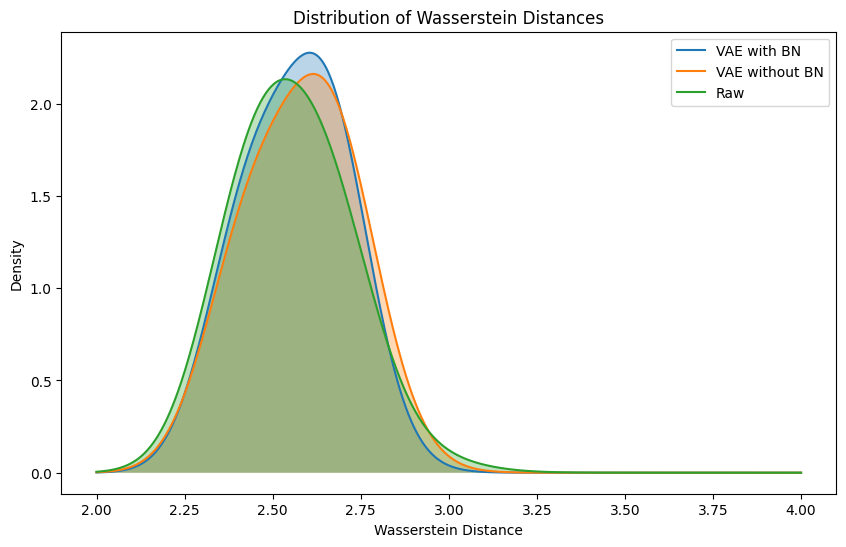

In [42]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

x = np.linspace(2, 4, 500)

kde_bn = gaussian_kde(distance_vae_total_bn, bw_method=0.8)
kde_non = gaussian_kde(distance_vae_total_non, bw_method=0.8)
kde_raw = gaussian_kde(distance_raw_total, bw_method=0.8)

plt.figure(figsize=(10, 6))
plt.plot(x, kde_bn(x), label='VAE with BN')
plt.plot(x, kde_non(x), label='VAE without BN')
plt.plot(x, kde_raw(x), label='Raw')
plt.fill_between(x, kde_bn(x), alpha=0.3)  # 可选：添加填充
plt.fill_between(x, kde_non(x), alpha=0.3)
plt.fill_between(x, kde_raw(x), alpha=0.3)

plt.xlabel('Wasserstein Distance')
plt.ylabel('Density')
plt.title('Distribution of Wasserstein Distances')
plt.legend()
plt.show()

## 样本零多样性验证

In [43]:
family_data_bn = family_data_bn.iloc[:, :10]

In [44]:
person_data_bn = person_data_bn.iloc[:, :51]

In [45]:
family_data_bn.columns = [i for i in range(family_data_bn.shape[1])]
person_data_bn.columns = [i for i in range(person_data_bn.shape[1])]

In [46]:
n = 33166
results_family_df = family_data_bn
results_family_df['have_student'] = results_family_df[[8,9]].values.argmax(axis=1)

results_family_df = results_family_df[[0,1,2,3,4,5,6,7,'have_student']]
results_family_df.columns = ['family_家庭成员数量','family_家庭工作人口数','family_机动车数量','family_脚踏自行车数量','family_电动自行车数量','family_摩托车数量','family_老年代步车数量','income','have_student']

results_family_df.rename(columns = {'income' : 'family_家庭年收入'}, inplace=True)
decode_results_family = test.decode_family_continuous(results_family_df)
for col in decode_results_family.keys():
    results_family_df[f'family_{col}'] = decode_results_family[col]


results_person_df = person_data_bn
results_person_df['gender'] = results_person_df[[1,2]].values.argmax(axis=1)
results_person_df['license'] = results_person_df[[3,4]].values.argmax(axis=1)
results_person_df['relation'] = results_person_df.iloc[:,5:21].values.argmax(axis=1)
results_person_df['education'] = results_person_df.iloc[:,21:30].values.argmax(axis=1)
results_person_df['occupation'] = results_person_df.iloc[:,30:50].values.argmax(axis=1)


results_person_df = results_person_df[[0,'gender','license','relation','education','occupation',50]]
results_person_df.columns = ['age','gender','license','relation','education','occupation','label']


results_person_df['age'] = test.decode_person_continuous(results_person_df['age'])['age_actual']


In [47]:
results_person_df_bn = results_person_df.copy()

In [48]:
ext_raw = compute_family_extensions(raw_family_df, raw_person_df)
ext_gen = compute_family_extensions(results_family_df, results_person_df)

extended_raw_family_df = pd.concat([raw_family_df.reset_index(drop=True), ext_raw], axis=1)
extended_results_family_df = pd.concat([results_family_df.reset_index(drop=True), ext_gen], axis=1)

In [49]:
extended_raw_family_df['license_ext'] = pd.cut(
    extended_raw_family_df['license_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_results_family_df['license_ext'] = pd.cut(
    extended_results_family_df['license_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_raw_family_df['gender_ext'] = pd.cut(
    extended_raw_family_df['gender_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_results_family_df['gender_ext'] = pd.cut(
    extended_results_family_df['gender_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_raw_family_df['education_ext'] = pd.cut(
    extended_raw_family_df['education_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_results_family_df['education_ext'] = pd.cut(
    extended_results_family_df['education_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_raw_family_df['employed_ext'] = pd.cut(
    extended_raw_family_df['employed_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

extended_results_family_df['employed_ext'] = pd.cut(
    extended_results_family_df['employed_ext'], 
    bins=np.linspace(0, 1, 6),   # 生成 [0,0.2,0.4,0.6,0.8,1.0]
    labels=False,                # 输出整数标签 0,1,2,3,4
    include_lowest=True          # 包含左边界0
)

In [50]:
extended_raw_family_df = extended_raw_family_df.drop_duplicates()

In [51]:
extended_results_family_df['keep'] = ~(bn_judge_total_bn & (vae_judge_total_bn))

In [52]:
extended_results_family_df = extended_results_family_df[extended_results_family_df['keep']]

In [53]:
extended_results_family_df = extended_results_family_df.drop_duplicates()

In [54]:
extended_results_family_df.drop(columns=['keep'], inplace=True)

In [55]:
common_cols = extended_results_family_df.columns

In [56]:
# df1 中有多少 unique 行出现在 df2 中
merged = extended_raw_family_df.merge(extended_results_family_df[common_cols], on=list(common_cols), how='inner')

coverage_ratio = len(merged) / len(extended_raw_family_df)

print("覆盖比例：", coverage_ratio)

覆盖比例： 0.8577412776277352


In [57]:
## 去除没有结构零的独特样本数
len(extended_results_family_df)

759904

## 结构零多样性验证

In [72]:
person_counts = np.round(family_data_non[0].values * 0.88397094 + 2.38862088).astype(int)
person_counts[person_counts<=0] = 0


In [73]:
family_data_non['id'] = range(len(family_data_non))

In [85]:
person_data_non['id'] = np.repeat(family_data_non['id'], person_counts).values

In [100]:
person_counts = np.round(family_data_bn[0].values * 0.88397094 + 2.38862088).astype(int)
person_counts[person_counts<=0] = 0

family_data_bn['id'] = range(len(family_data_bn))
person_data_bn['id'] = np.repeat(family_data_bn['id'], person_counts).values

In [ ]:
person_data_bn['huzhu'] = person_data_bn['relation'] == 0

In [107]:
person_data_non['huzhu'] = person_data_non['relation'] == 0


In [87]:
family_data_non['invalid'] = (bn_judge_total_non & (vae_judge_total_non))

In [89]:
family_data_non[family_data_non['invalid']]

,0,1,2,3,4,5,6,7,8,9,have_student,id,invalid
3,-1.615578,-1.969721,-1.084712,-0.832152,-1.084868,-0.164980,0.896887,0.218468,0.904750,0.095250,0,3,True
40,3.423513,2.262115,0.754556,-1.007581,0.303144,-0.234363,-0.319222,1.441782,0.000026,0.999974,1,40,True
55,2.187442,-0.494091,-0.523845,0.824986,0.295421,-0.133529,-0.349914,0.072963,0.001435,0.998565,1,55,True
68,1.478382,0.730873,0.930813,0.873763,0.360241,-0.193291,0.174599,1.963470,0.000017,0.999983,1,68,True
71,1.934694,-1.886742,0.996560,0.788907,0.286679,-0.256050,-0.495269,-0.145723,0.130123,0.869877,1,71,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14098507,0.661490,-1.734631,-0.942913,-0.238866,-0.206459,-0.217959,2.785462,-0.529162,0.003921,0.996079,1,14098507,True
14098518,1.731612,0.892597,-0.907886,0.695691,0.257514,-0.151555,-0.388218,-0.574294,0.000023,0.999977,1,14098518,True
14098562,3.400310,0.791568,0.878561,1.038483,0.239365,-0.071795,-0.257201,0.415889,0.002406,0.997594,1,14098562,True
14098588,-1.343806,0.104560,0.133018,-0.883659,-0.302870,-0.049933,-0.300195,-0.112210,0.999980,0.000020,0,14098588,True


In [90]:
person_data_non_invalid = pd.merge(person_data_non, family_data_non[family_data_non['invalid']][['id']])

In [92]:
person_data_non_invalid = person_data_non_invalid[[0,'gender','license','relation','education','occupation',50,'id']]
person_data_non_invalid.columns = ['age','gender','license','relation','education','occupation','label','id']


person_data_non_invalid['age'] = test.decode_person_continuous(person_data_non_invalid['age'])['age_actual']

In [98]:
person_data_non_invalid.head(50)

,age,gender,license,relation,education,occupation,label,id
0,15,1,0,0,2,14,0.997767,3
1,8,0,1,9,4,14,0.981399,40
2,11,1,1,0,5,7,0.999218,40
3,9,0,1,5,2,2,0.999210,40
4,6,1,0,4,0,2,0.997142,40
5,9,1,1,15,3,18,0.999243,40
6,9,0,1,0,3,3,0.999861,55
7,10,1,0,0,2,14,0.995789,55
8,12,0,0,4,3,2,0.998776,55
9,11,0,0,9,5,3,0.998864,55


In [58]:
# df1 中有多少 unique 行出现在 df2 中
merged = extended_results_family_df.merge(extended_raw_family_df[common_cols], on=list(common_cols), how='inner')

coverage_ratio = len(merged) / len(extended_results_family_df)

print("覆盖比例：", coverage_ratio)


覆盖比例： 0.020478902598222933


In [86]:
wrongdata_non = total_ls_raw_non[(bn_judge_total_non & (vae_judge_total_non))].reshape(-1,51)

In [87]:
wrongdata_non = pd.DataFrame(wrongdata_non)

In [90]:
wrongdata_non['valid'] = wrongdata_non.sum(axis = 1) != 0

In [93]:
valid_wrongdata_non = wrongdata_non[wrongdata_non['valid']]

In [94]:
valid_wrongdata_non['gender'] = valid_wrongdata_non[[1,2]].values.argmax(axis=1)
valid_wrongdata_non['license'] = valid_wrongdata_non[[3,4]].values.argmax(axis=1)
valid_wrongdata_non['relation'] = valid_wrongdata_non.iloc[:,5:21].values.argmax(axis=1)
valid_wrongdata_non['education'] = valid_wrongdata_non.iloc[:,21:30].values.argmax(axis=1)
valid_wrongdata_non['occupation'] = valid_wrongdata_non.iloc[:,30:50].values.argmax(axis=1)


valid_wrongdata_non = valid_wrongdata_non[[0,'gender','license','relation','education','occupation',50]]
valid_wrongdata_non.columns = ['age','gender','license','relation','education','occupation','label']


valid_wrongdata_non['age'] = test.decode_person_continuous(valid_wrongdata_non['age'])['age_actual']

In [101]:
valid_wrongdata_non.value_counts(subset=['age','gender','license','relation','education','occupation']).head(10)

age  gender  license  relation  education  occupation
7    1       1        0         6          1             2280
8    1       1        0         6          1             2047
6    1       1        0         6          1             1960
9    1       1        0         6          1             1760
8    1       1        0         6          6             1749
7    1       1        0         6          2             1716
                                           6             1685
8    1       1        0         6          2             1681
9    1       1        0         6          6             1474
7    1       1        0         6          3             1468
Name: count, dtype: int64

In [84]:
total_ls_raw_bn[(bn_judge_total_bn & (vae_judge_total_bn))].shape

(5, 8, 51)

In [106]:
results_person_df_non[(results_person_df_non['age'] >= 0)&
                      (results_person_df_non['age'] <= 3)&
                      (results_person_df_non['education'].isin([6,7]))]

,age,gender,license,relation,education,occupation,label
3,3,1,0,6,6,15,0.990702
30,3,0,1,0,6,4,0.999880
46,3,1,0,6,7,2,0.999412
247,3,0,0,7,6,6,0.999156
277,2,0,1,15,6,9,0.997998
...,...,...,...,...,...,...,...
29310868,1,0,1,5,6,13,0.998525
29310901,3,1,1,4,6,13,0.999746
29311091,3,1,1,7,6,1,0.998696
29311134,3,0,1,15,6,4,0.999677


In [107]:
results_person_df_bn[(results_person_df_bn['age'] >= 0)&
                      (results_person_df_bn['age'] <= 3)&
                      (results_person_df_bn['education'].isin([7,6]))]

,age,gender,license,relation,education,occupation,label
78,3,1,0,0,7,3,0.999800
159,3,0,0,0,6,2,0.998166
244,2,1,1,5,6,3,0.999862
449,3,0,0,0,6,1,0.999384
563,3,1,0,10,6,2,0.999241
...,...,...,...,...,...,...,...
29044522,3,1,0,6,6,13,0.998870
29044545,3,1,1,2,6,6,0.999141
29044774,3,1,0,10,7,15,0.990804
29044955,3,1,0,3,7,3,0.992557


In [108]:
extended_results_family_df

,family_家庭成员数量,family_家庭工作人口数,family_机动车数量,family_脚踏自行车数量,family_电动自行车数量,family_摩托车数量,family_老年代步车数量,family_家庭年收入,have_student,have_elder_ext,license_ext,gender_ext,education_ext,employed_ext
0,2,0,1,0,0,0,0,1,0,1,0.0,2.0,0.0,0.0
1,2,0,0,0,0,0,0,1,0,1,2.0,2.0,0.0,2.0
2,2,2,0,1,1,0,0,1,0,1,2.0,4.0,0.0,4.0
3,2,2,0,0,1,0,0,2,0,0,4.0,4.0,2.0,2.0
4,5,1,1,0,0,0,0,2,1,1,2.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14098421,2,0,1,1,1,0,2,2,0,1,0.0,4.0,2.0,2.0
14098436,3,0,1,2,1,0,1,1,0,1,0.0,3.0,1.0,3.0
14098484,3,1,0,0,2,0,0,2,1,0,1.0,0.0,1.0,0.0
14098580,4,2,1,1,2,0,0,2,1,1,2.0,3.0,4.0,2.0
